# Introduction

##### В този Notebook ще разгледаме данните от Home Credit Default Risk Competition, проведено в Kaggle и ще се опитаме да предскажем дали даден клиент ще си изплати заема.

За състезанието са предоставен 7 различни източника на данни, но ние ще разгледаме само главния трейнинг датасет с информация за всеки клиент за заем на Home Credit. За всеки заем има отделен ред в таблицата с идентификатор SK_ID_CURR. В тези данни има колона TARGET със стойности 0 (ако заемът е изплатен) и 1 (ако заемът не е изплатен).

In [1]:
import sys

import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
# training data
train = pd.read_csv('application_train.csv', index_col=['SK_ID_CURR'])

In [4]:
train.shape

(307511, 121)

In [5]:
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

Exploratory Data Analysis е процес, в който търсим аномалии, модели и зависимости между фичърите. Главната цел е да разберем значението на фичърите.

### Explore TARGET column

In [6]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

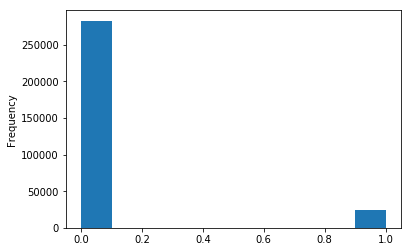

In [7]:
train['TARGET'].astype(int).plot.hist();

Заемите, които са били изплатени, са доста повече от неизплатените. Този дисбаланс би могъл да представлява проблем.

### Examine Missing Data

In [8]:
# calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
               + str(mis_val_table_ren_columns.shape[0]) +
              " of them have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values = missing_values_table(train)
missing_values.head(20)

The dataframe has 121 columns.
67 of them have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Виждаме, че има доста голям процент на липсващи стойности, но е твърде рано, за да решим дали да премахнем някои колони, защотото: 1) Можем да използваме XGBoost, който се справя с липсващите колони 2) Не знаем коя колона, колко голямо значение има

### Examine Column Types

In [10]:
train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

### Explore Categorical columns

In [11]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

In [12]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

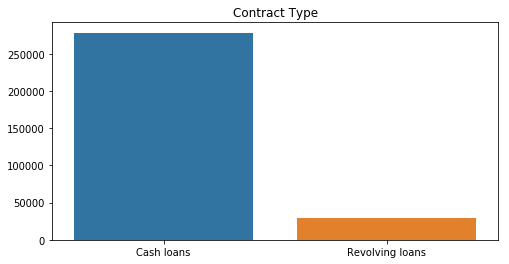

In [13]:
plot_categorical(data=train, col='NAME_CONTRACT_TYPE', title='Contract Type');

Заемите от тип "Revolving loans" са доста малка част от общия брой (около 10%), тоест типът едва ли оказва голямо влияние върху връщането на заемите.
На по-късен етап ще разгледаме зависимостта между типът на заемът и стойността на "TARGET".

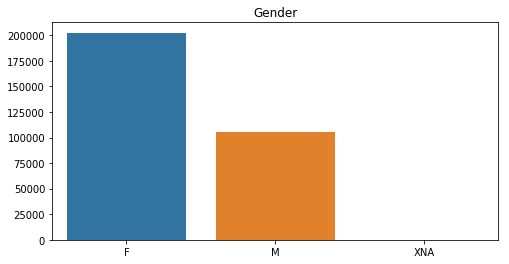

In [14]:
plot_categorical(data=train, col='CODE_GENDER', title='Gender');

In [15]:
train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Жените клиенти са почти два пъти повече от мъжете. Ще трябва да обаче да видим кой е по-склонен да връща заемите.

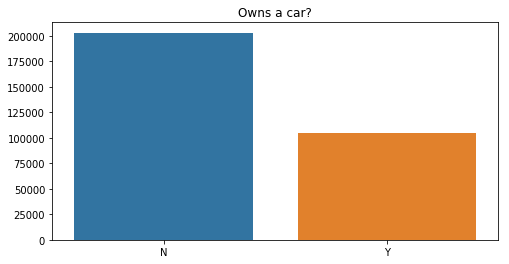

In [16]:
plot_categorical(data=train, col='FLAG_OWN_CAR', title='Owns a car?');

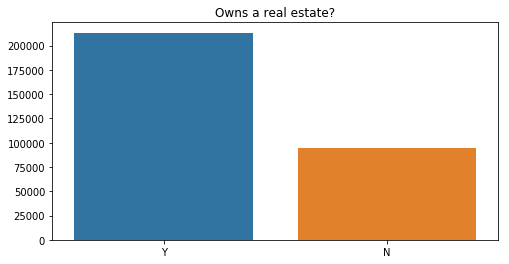

In [17]:
plot_categorical(data=train, col='FLAG_OWN_REALTY', title='Owns a real estate?');

Виждаме, че повечето клиенти не притежават кола, но пък повече от 50% притежават недвижим имот.

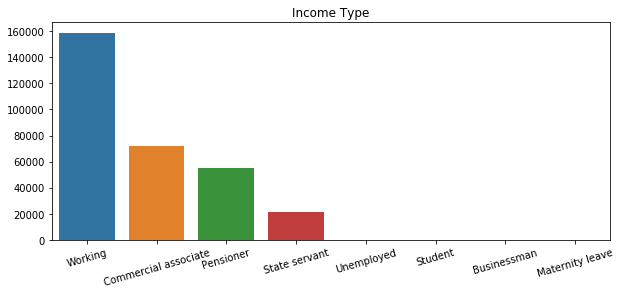

In [18]:
plot_categorical(data=train, col='NAME_INCOME_TYPE', size=[10 ,4], xlabel_angle=16, title='Income Type');

In [19]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Доходите на повечето клиенти идват от работа, следвани от търговски сътрудници, пенсионери, държавни служители...

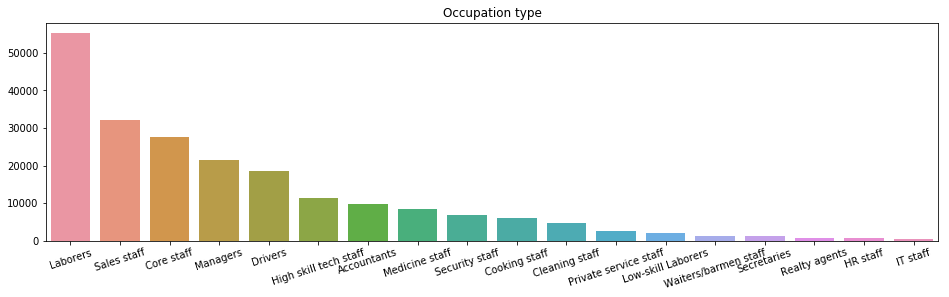

In [20]:
plot_categorical(data=train, col='OCCUPATION_TYPE', size=[16 ,4], xlabel_angle=18, title='Occupation type');

Повечето заеми са изтеглени от работници ("Laborers"), след това от продавачи, "Core staff",... ИТ персонал теглят най-рядко.

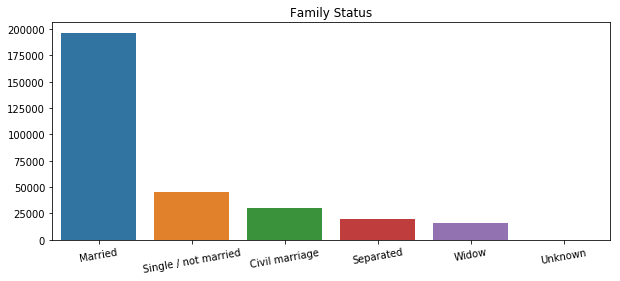

In [21]:
plot_categorical(data=train, col='NAME_FAMILY_STATUS', size=[10 ,4], xlabel_angle=10, title='Family Status');

Главно клиентите са женени, следвани от "Single/not married"

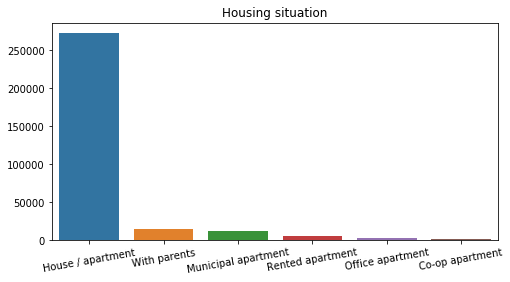

In [22]:
plot_categorical(data=train, col='NAME_HOUSING_TYPE', xlabel_angle=10, title='Housing situation');

In [23]:
train['NAME_HOUSING_TYPE'].value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

Над 250 000 от клиентите казват, че живеят в собствена къща/апартамент. Останалите категории са незначителен брой

### Examine Categorical Features by Target

Нека отново рагледаме уникалните стойности на някои от категорийните колони, но този път как влияят спрямо TARGET колоната

In [24]:
def plot_categorical_by_target(data, col, size=[12 ,6], xlabel_angle=0, title=''):
    '''use it to compare the distribution between label 1 and label 0'''
    plt.figure(figsize = size)
    l0 = data.loc[data.TARGET==0, col].value_counts()
    l1 = data.loc[data.TARGET==1, col].value_counts()
    plt.subplot(1,2,1)
    sns.barplot(x = l0.index, y=l0.values)
    plt.title('Paid: '+title)
    plt.xticks(rotation=xlabel_angle)
    plt.subplot(1,2,2)
    sns.barplot(x = l1.index, y=l1.values)
    plt.title('Not Paid: '+title)
    plt.xticks(rotation=xlabel_angle)
    plt.show()

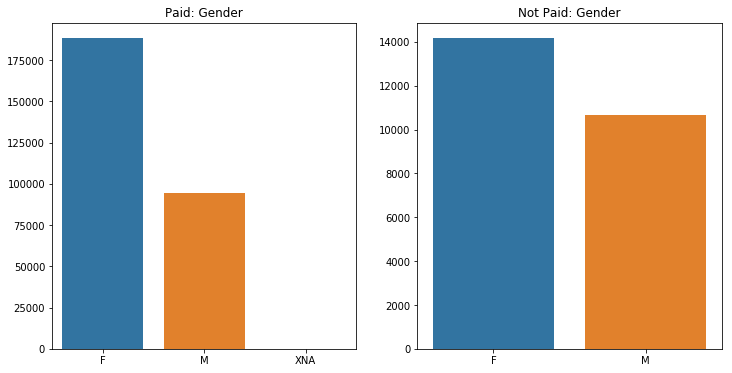

In [25]:
plot_categorical_by_target(train, 'CODE_GENDER', title='Gender')

Виждам, че мъжете имат по-висок шанс да не си платят заемите, спрямо жените

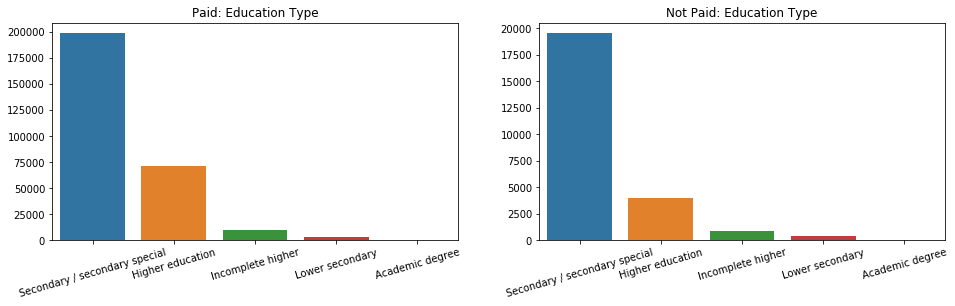

In [26]:
plot_categorical_by_target(train, 'NAME_EDUCATION_TYPE', size=[16, 4], xlabel_angle=16, title='Education Type')

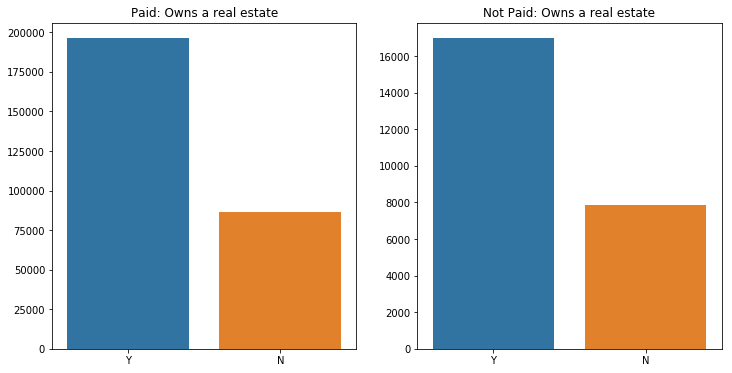

In [27]:
plot_categorical_by_target(train, 'FLAG_OWN_REALTY', title='Owns a real estate')

Повечето клиенти, които притежават недвижим имот все пак си плащат заемите (под 8% не ги плащат)

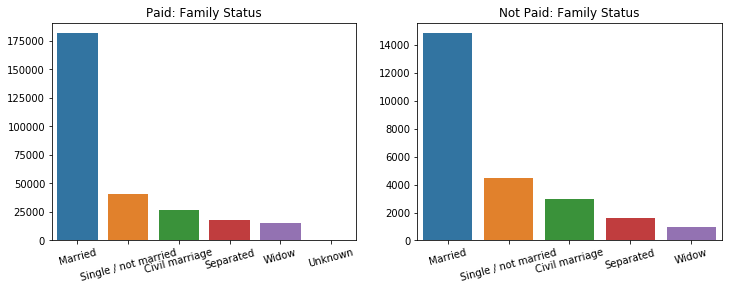

In [28]:
plot_categorical_by_target(train, 'NAME_FAMILY_STATUS', size=[12, 4], xlabel_angle=15, title='Family Status')

Доста висок процент от "Single/not married" и "Civil merrage" не си връщат заемите (около 10%)

### Explore Numerical Features

In [29]:
def plot_numerical(data, col, size=[8, 4], bins=50):
    '''use this for ploting the distribution of numercial features'''
    plt.figure(figsize=size)
    plt.title("Distribution of %s" % col)
    sns.distplot(data[col].dropna(), kde=True,bins=bins)
    plt.show()

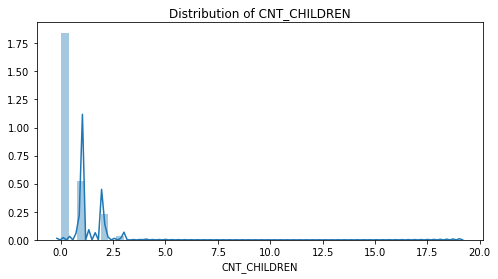

In [30]:
plot_numerical(train, col='CNT_CHILDREN')

Повечето теглили кредит нямат деца

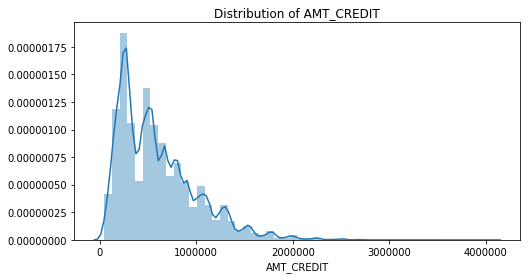

In [31]:
# големина на кредита
plot_numerical(train, col='AMT_CREDIT')

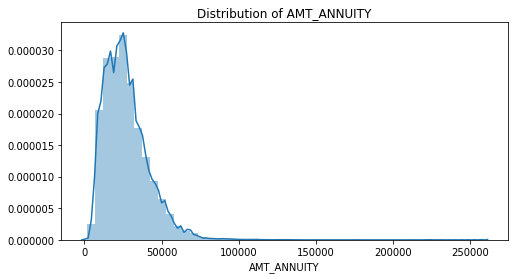

In [32]:
# годишно
plot_numerical(train, col='AMT_ANNUITY')

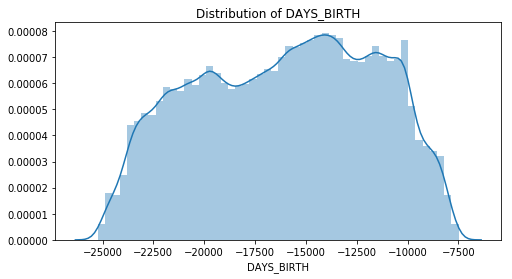

In [33]:
# години на клиента в дни в момента на постъпване
plot_numerical(train, col='DAYS_BIRTH')

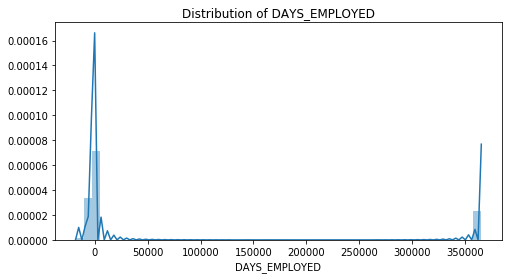

In [34]:
# работни дни на клиента в момента на постъпване
plot_numerical(train, col='DAYS_EMPLOYED')

Тази графика изглежда странно, но няма как да сме сигурни какво точно означават тези данни. Възможно е отрицателните стойности да означават, че клиента е безработен. Най-положителните стойности определно не изглеждат вярни, трудно е някой да е работил над 100 години.

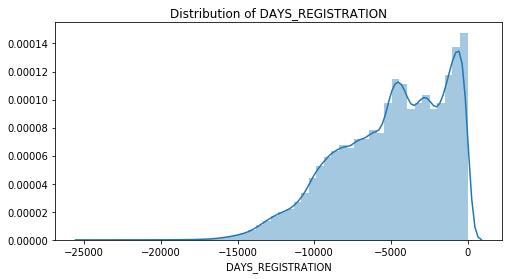

In [35]:
plot_numerical(train, col='DAYS_REGISTRATION')

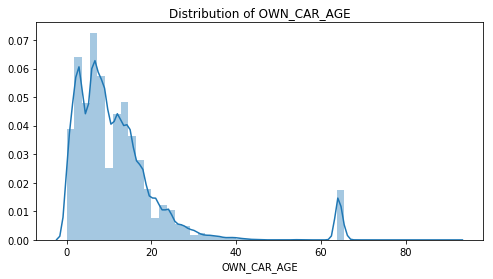

In [36]:
plot_numerical(train, col='OWN_CAR_AGE')

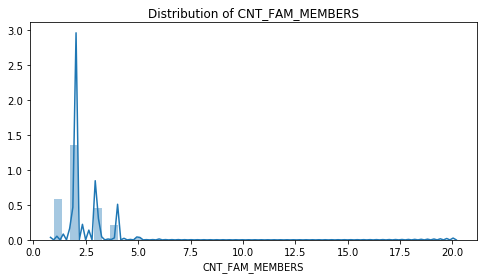

In [37]:
plot_numerical(train, col='CNT_FAM_MEMBERS')

Най-много са клиентите с двучленно семейство, следвани с 1 (single) и 3 (с по едно дете)

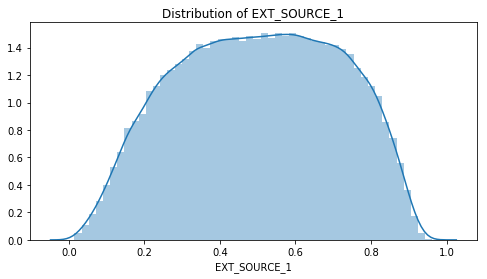

In [38]:
plot_numerical(train, col='EXT_SOURCE_1')

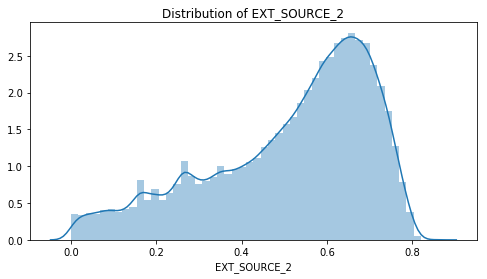

In [39]:
plot_numerical(train, col='EXT_SOURCE_2')

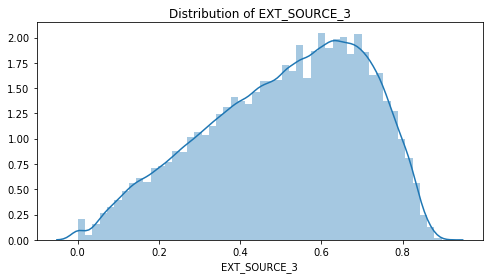

In [40]:
plot_numerical(train, col='EXT_SOURCE_3')

### Examine Numerical Columns by Target

Да разгледаме разпределението и на числовите колони спрямо TARGET

In [41]:
def plot_numerical_by_target(feature,label_rotation=False,horizontal_layout=True):
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, ax = plt.subplots(ncols=1, figsize=(12,6))
    else:
        fig, ax = plt.subplots(nrows=1, figsize=(12,14))
    sns.set_color_codes("pastel")
    
    s = sns.barplot(ax=ax, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

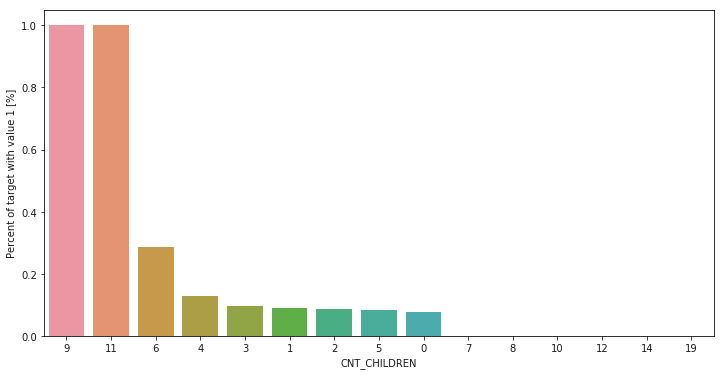

In [42]:
plot_numerical_by_target("CNT_CHILDREN")

Клиентите с по 9 и 11 деца на 100% не си връщат заемите. От тези без деца, с 1, 2, 3 и 5 около 10% не ги връщат, а тези с 4 / 6 са 15 / 25 %. 

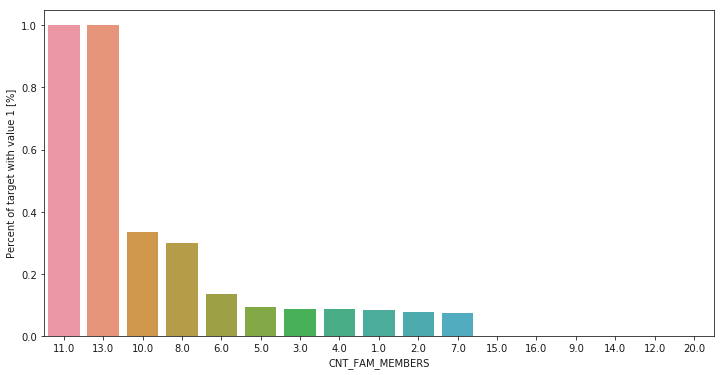

In [43]:
plot_numerical_by_target('CNT_FAM_MEMBERS');

100% от семействата с брой членове 11/13 не си връщат заемите. Други семейства с 8 / 10 - около 30%. Останалите с 6 и по-малко - около 10%.

### Explore for Outliers

In [44]:
train["DAYS_BIRTH"].head()

SK_ID_CURR
100002    -9461
100003   -16765
100004   -19046
100006   -19005
100007   -19932
Name: DAYS_BIRTH, dtype: int64

Виждаме че стойностите са отрицателни. Tова е възрастта на клиента в дни в момента на постъпление.
Можем да ги умножим по -1 и да разделим на броя дни в годината, за да получим приблизителните години.

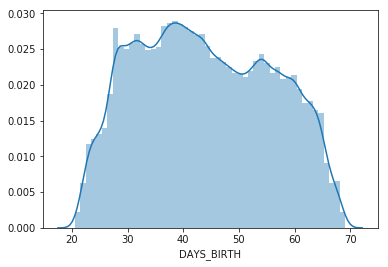

In [45]:
sns.distplot(train['DAYS_BIRTH']/-365);

In [46]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Тук нямаме аномалии

In [47]:
(train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Това вече изглежда странно. Максималната стойност е около 1000 работни години.

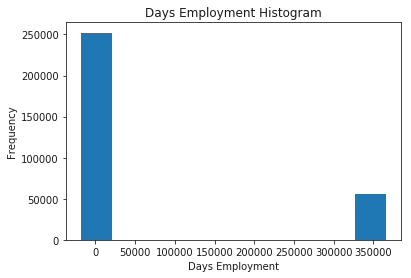

In [48]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Ще направим нова колона само за аномалиите (евентуално ако по-късно ни потрябват тези стойности) и ще ги превърнем в 'nan' в оригиналната колона.

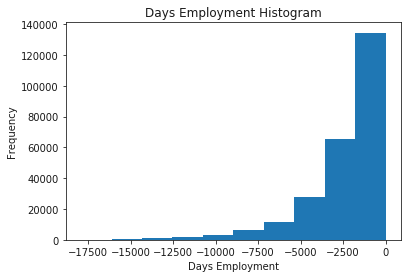

In [49]:
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Така вече графиката изглежда по-добре

In [50]:
# Check other columns starting with DAYS for outliers

train['DAYS_REGISTRATION'].describe()

count    307511.000000
mean      -4986.120328
std        3522.886321
min      -24672.000000
25%       -7479.500000
50%       -4504.000000
75%       -2010.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [51]:
train['DAYS_LAST_PHONE_CHANGE'].describe()

count    307510.000000
mean       -962.858788
std         826.808487
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [52]:
train['DAYS_ID_PUBLISH'].describe()

count    307511.000000
mean      -2994.202373
std        1509.450419
min       -7197.000000
25%       -4299.000000
50%       -3254.000000
75%       -1720.000000
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

Виждаме, че във видяните по-горе колони не се виждат някакви очевидни outliers.

### Examine Correlations

In [53]:
correlations = train.corr()['TARGET'].sort_values()

print("Most Possitive: \n", correlations.tail(10), '\n')
print("Most Negative: \n", correlations.head(10))

Most Possitive: 
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64 

Most Negative: 
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


DAYS_BIRTH и DAYS_EMPLOYED имат най-голямо влияние върху модела

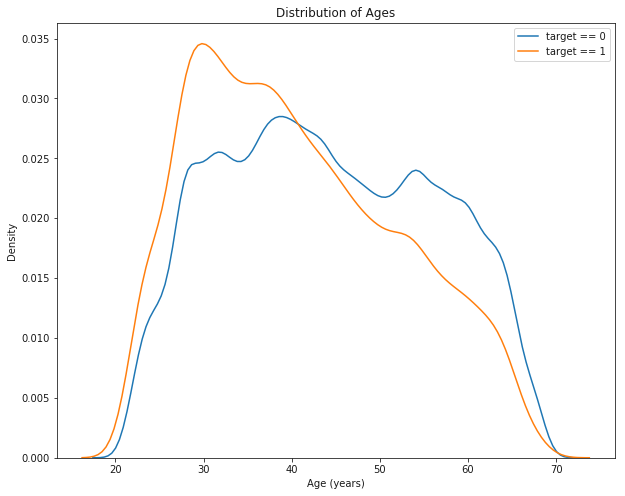

In [54]:
train['DAYS_BIRTH']=abs(train['DAYS_BIRTH'])
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

От графиката се вижда, че повече млади хора не си плащат заемите, и съответно повечето възрастни - ги плащат

Може да групираме годините в интервали от 5 години. Така ще видим съотношението на кредитие, които не са изплатени във всяка категория

In [55]:
age_data = train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
SK_ID_CURR,,,,
100002,1,9461,25.920548,"(25.0, 30.0]"
100003,0,16765,45.931507,"(45.0, 50.0]"
100004,0,19046,52.180822,"(50.0, 55.0]"
100006,0,19005,52.068493,"(50.0, 55.0]"
100007,0,19932,54.608219,"(50.0, 55.0]"
100008,0,16941,46.413699,"(45.0, 50.0]"
100009,0,13778,37.747945,"(35.0, 40.0]"
100010,0,18850,51.643836,"(50.0, 55.0]"
100011,0,20099,55.065753,"(55.0, 60.0]"


In [56]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


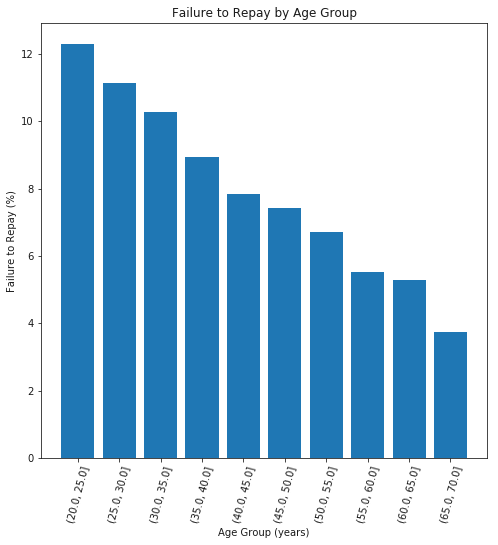

In [57]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Тук още по-ясно се вижда, че колкото по-млади са клиентите, толкова по-рядко си плащат заемите. Повече от 10% от първите 3 категории имат тенденция да не ти плащат заемите, докато при най-възрастните процента е под 4.

Нека разгледаме фичърите с най-голямо отрицателно влияние. Това са: EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

In [58]:
# Show the correlations
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Може да видим разпределението на тези фичъри спрямо TARGET

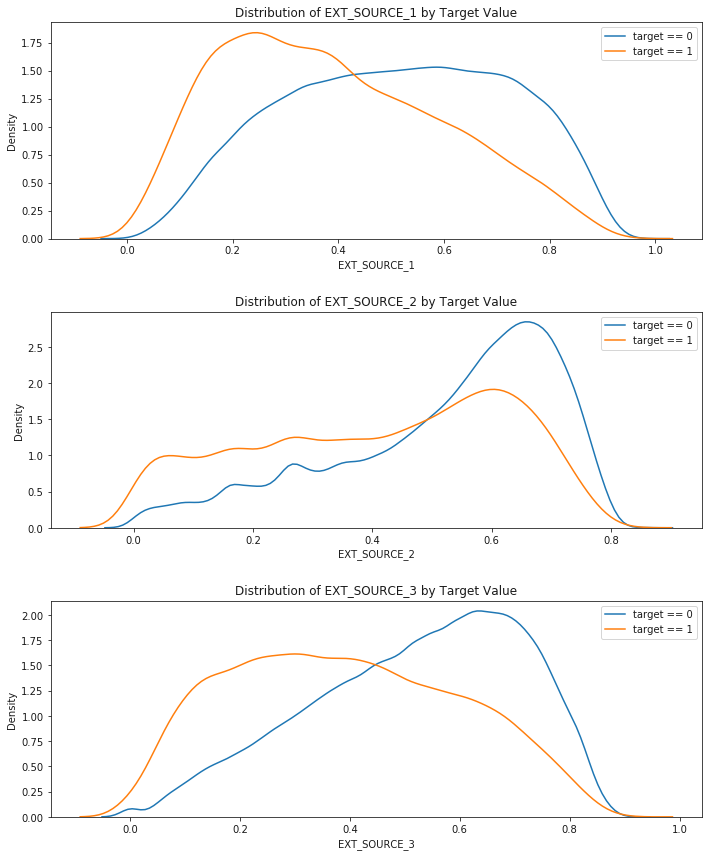

In [59]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Най-голямо влияние върху TARGET оказва EXT_SOURCE_3. Вероятно е този фичър да има връзка (макар и слаба) с връщането на заемите.

# Feature Engineering

### Create new Features

In [60]:
# create new feature from the credit amount of the loan and loan annuity
train['TERM'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

In [61]:
# actual credit larger than goods price
train['OVER_EXPECT_CREDIT'] = (train['AMT_CREDIT'] > train['AMT_GOODS_PRICE']).map({False:0, True:1})

In [62]:
# mean and sum of all building AVG score
train['MEAN_BUILDING_SCORE_AVG'] = train.iloc[:, 43:57].mean(skipna=True, axis=1)
train['TOTAL_BUILDING_SCORE_AVG'] = train.iloc[:, 43:57].sum(skipna=True, axis=1)

In [63]:
# total number of provided documents
train['FLAG_DOCUMENT_TOTAL'] = train.iloc[:, 95:115].sum(axis=1)

In [64]:
# total number of enquiries
train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = train.iloc[:, 115:121].sum(axis=1)

In [65]:
cols_to_drop = list(train.iloc[:, 43:57].columns) + list(train.iloc[:, 95:115].columns) + list(train.iloc[:, 115:121].columns)

train.drop(columns=cols_to_drop, inplace=True)

## Explore Bureau Data

Данните в bureau.csv ни дават информация за предишни заеми на клиентите от други институции. За всеки заем има отделен ред

In [66]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### Count of Client's previous loans

In [67]:
# Group by the client id (SK_ID_CURR) and count the number of previous loans
count_of_previous_loans = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'COUNT_OF_PREV_LOANS'})
count_of_previous_loans.head()

,SK_ID_CURR,COUNT_OF_PREV_LOANS
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [68]:
# join with the training dataframe
train = train.merge(count_of_previous_loans, on='SK_ID_CURR', how='left')

# fill the missing values with 0
train['COUNT_OF_PREV_LOANS'] = train['COUNT_OF_PREV_LOANS'].fillna(0)

In [69]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED_ANOM,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,COUNT_OF_PREV_LOANS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,-1134.0,False,16.461104,1,0.144336,2.0207,1,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-828.0,False,36.234085,1,0.206343,2.8888,1,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-815.0,False,20.000000,0,NaN,0.0000,0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-617.0,False,10.532818,1,NaN,0.0000,1,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1106.0,False,23.461618,0,NaN,0.0000,1,0.0,1.0


In [70]:
train['TARGET'].corr(train['COUNT_OF_PREV_LOANS'])

-0.01001971567068405

Да добавим към train и колоните съдържащи числа. Тъй като имаме по няколко реда за един човек(SK_ID_CURR) можем да агрегираме стойностите от отделните колони в един ред, като групираме по SK_ID_CURR и вземем min,max,mean,sum.
Абстрахираме се от count тъй като той дефакто е брой предишни заеми, което вече сме добавили.

In [71]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg([ 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR  DAYS_CREDIT                  CREDIT_DAY_OVERDUE              \
                     mean  max   min   sum               mean max min sum   
0     100001  -735.000000  -49 -1572 -5145                0.0   0   0   0   
1     100002  -874.000000 -103 -1437 -6992                0.0   0   0   0   
2     100003 -1400.750000 -606 -2586 -5603                0.0   0   0   0   
3     100004  -867.000000 -408 -1326 -1734                0.0   0   0   0   
4     100005  -190.666667  -62  -373  -572                0.0   0   0   0   

  DAYS_CREDIT_ENDDATE   ...    AMT_CREDIT_SUM_OVERDUE      DAYS_CREDIT_UPDATE  \
                 mean   ...                       min  sum               mean   
0           82.428571   ...                       0.0  0.0         -93.142857   
1         -349.000000   ...                       0.0  0.0        -499.875000   
2         -544.500000   ...                       0.0  0.0        -816.000000   
3         -488.500000   ...                       0.0  0.0        -532.000000   
4          439.333333   ...                       0.0  0.0         -54.333333   

                    AMT_ANNUITY                         
   max   min   sum         mean      max  min      sum  
0   -6  -155  -652  3545.357143  10822.5  0.0  24817.5  
1   -7 -1185 -3999     0.000000      0.0  0.0      0.0  
2  -43 -2131 -3264          NaN      NaN  NaN      0.0  
3 -382  -682 -1064          NaN      NaN  NaN      0.0  
4  -11  -121  -163  1420.500000   4261.5  0.0   4261.5  

[5 rows x 49 columns]

Сега трябва да ги разделим в отделни колони за да може да ги добавим към train

In [72]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))


In [73]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,...,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,-735.000000,-49,-1572,-5145,0.0,0,0,0,82.428571,...,0.0,0.0,-93.142857,-6,-155,-652,3545.357143,10822.5,0.0,24817.5
1,100002,-874.000000,-103,-1437,-6992,0.0,0,0,0,-349.000000,...,0.0,0.0,-499.875000,-7,-1185,-3999,0.000000,0.0,0.0,0.0
2,100003,-1400.750000,-606,-2586,-5603,0.0,0,0,0,-544.500000,...,0.0,0.0,-816.000000,-43,-2131,-3264,NaN,NaN,NaN,0.0
3,100004,-867.000000,-408,-1326,-1734,0.0,0,0,0,-488.500000,...,0.0,0.0,-532.000000,-382,-682,-1064,NaN,NaN,NaN,0.0
4,100005,-190.666667,-62,-373,-572,0.0,0,0,0,439.333333,...,0.0,0.0,-54.333333,-11,-121,-163,1420.500000,4261.5,0.0,4261.5


In [74]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,-499.875,-7.0,-1185.0,-3999.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,-816.000,-43.0,-2131.0,-3264.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,-532.000,-382.0,-682.0,-1064.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,-783.000,-783.0,-783.0,-783.0,NaN,NaN,NaN,0.0


In [75]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

In [76]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_CREDIT_UPDATE_max', 0.028233546896535826)]

Виждаме, че нито една от колоните не е значимо свързана с TARGET.

Сега да направим същото с категорийните колони.

In [77]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [78]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      ...  CREDIT_TYPE_Microloan       \
                                  sum mean ...                    sum mean   
SK_ID_CURR                                 ...                               
100001                              7  1.0 ...                      0  0.0   
100002                              8  1.0 ...                      0  0.0   
100003                              4  1.0 ...                      0  0.0   
100004                              2  1.0 ...                      0  0.0   
100005                              3  1.0 ...                      0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [79]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [80]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## One Hot Encoder

Нека отново погледнем уникалните стойности в object колоните

In [81]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

In [82]:
# We see that ORGANIZATION_TYPE has more than 50 different values
# so for now we will drop the column, because after one hot encoding
# We will have 50+ columns only for ORGANIZATION TYPE

train.drop(columns=["ORGANIZATION_TYPE"], inplace=True)

# Get categorical column names for cols with more than 2 uniqe values
# We will OneHotEncode those columns later.
categorical_cols = train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
categorical_cols = categorical_cols[categorical_cols>2].index

Тези, които са само с две уникални стойности, може да ги трансформираме в колони съдържащи булеви стойности (0, 1). Това ще го направим с Label encoding. Останалите колони ще ги трансформираме чрез One-Hot-Encodint (get dummies).

In [83]:
# labelEncode the object cols with less than 2 unique values
le = LabelEncoder()
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            train[col] = le.transform(train[col])

In [84]:
train.select_dtypes('object').isnull().sum()

CODE_GENDER                        0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

Виждаме, че има колони, които имат голям процент празни стойности. За сега ще махнем тези колони (OCCUPATION_TYPE, FONDKAPREMONT_MODE, HOUSETYPE_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE). Колоната NAME_TYPE_SUITE има сравнително малко празни стойности. Можем да махнем тези 1292 реда от dataset-a, без да окаже голямо влияние върху количеството данни, с което тренираме.

In [85]:
train.drop(columns=["OCCUPATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"], inplace=True)

train = train[train['NAME_TYPE_SUITE'].notnull()]

In [86]:
train.select_dtypes('object').isnull().sum()

CODE_GENDER                   0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
WEEKDAY_APPR_PROCESS_START    0
dtype: int64

Вече нямаме празни стойности в object колоните. Да видим какво се случва в останалите колони.

In [87]:
train.isnull().sum().sort_values(ascending=False)

bureau_AMT_ANNUITY_mean        226439
bureau_AMT_ANNUITY_min         226439
bureau_AMT_ANNUITY_max         226439
COMMONAREA_MODE                213989
COMMONAREA_MEDI                213989
NONLIVINGAPARTMENTS_MEDI       212655
NONLIVINGAPARTMENTS_MODE       212655
LIVINGAPARTMENTS_MEDI          209350
LIVINGAPARTMENTS_MODE          209350
FLOORSMIN_MEDI                 207800
FLOORSMIN_MODE                 207800
YEARS_BUILD_MODE               203660
YEARS_BUILD_MEDI               203660
OWN_CAR_AGE                    202048
LANDAREA_MEDI                  181869
LANDAREA_MODE                  181869
BASEMENTAREA_MODE              179239
BASEMENTAREA_MEDI              179239
EXT_SOURCE_1                   172652
NONLIVINGAREA_MODE             169016
NONLIVINGAREA_MEDI             169016
ELEVATORS_MEDI                 163255
ELEVATORS_MODE                 163255
APARTMENTS_MEDI                155446
APARTMENTS_MODE                155446
ENTRANCES_MEDI                 154222
ENTRANCES_MO

Виждаме, че има доста колони с празни стойности. Тъй като са числови, можем за момента да заместим празните полета с 0.

In [88]:
train.fillna(0, inplace=True)
train_target = train["TARGET"]
train_features = train.drop(columns=["TARGET"])

In [89]:
# get categorical columns
categorical_cols = train_features.select_dtypes("object").columns
print(categorical_cols)

Index(['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START'],
      dtype='object')


In [90]:
# label encode the rest of the categorical columns
for col in categorical_cols:
    le.fit(train_features[col])
    train_features[col] = le.transform(train_features[col])

label_encoded = train_features[categorical_cols]
label_encoded.head(10)

,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START
0,1,6,7,4,3,1,6
1,0,1,4,1,1,1,1
2,1,6,7,4,3,1,1
3,0,6,7,4,0,1,6
4,1,6,7,4,3,1,4
5,1,5,4,4,1,1,6
6,0,6,1,1,1,1,3
7,1,6,4,1,1,1,1
8,0,0,3,4,1,1,6
9,1,6,7,4,3,1,4


In [91]:
# OneHotEncode these columns 
one_hot_enc = OneHotEncoder().fit(label_encoded)

one_hot_enc.transform(label_encoded).shape

(306219, 41)

От останалите 7 категорийни колони, след OneHotEncode имаме 41 нови колони. Сега можем да махнем оригиналните колони от трейнинг сета и да добавим новите.

In [92]:
train_features.drop(columns=categorical_cols, inplace=True)

train_features = pd.np.concatenate([train_features,one_hot_enc.transform(label_encoded).todense()], axis=1)

In [93]:
train_features

matrix([[100002, 0, 0, ..., 0.0, 0.0, 1.0],
        [100003, 0, 0, ..., 0.0, 0.0, 0.0],
        [100004, 1, 1, ..., 0.0, 0.0, 0.0],
        ...,
        [456253, 0, 0, ..., 1.0, 0.0, 0.0],
        [456254, 0, 0, ..., 0.0, 0.0, 1.0],
        [456255, 0, 0, ..., 1.0, 0.0, 0.0]], dtype=object)

# Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.3, 
                                                    random_state=4330)

print("Shape of x_train: ", x_train.shape, "\nShape of x_test: ", x_test.shape, "\nShape of y_train: ", y_train.shape, "\nShape of y_test: ", y_test.shape)

Shape of x_train:  (214353, 211) 
Shape of x_test:  (91866, 211) 
Shape of y_train:  (214353,) 
Shape of y_test:  (91866,)


In [95]:
# Make the model with the specified regulari zation parameter
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(x_train, y_train)

print("Train Score: ", log_reg.score(x_train, y_train))
print("Test Score: ", log_reg.score(x_test, y_test))

Train Score:  0.919749198751592
Test Score:  0.9175102867219646


Получаваме доста добър резултат. 

# Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)

random_forest.fit(x_train, y_train)

print("Train score: ", random_forest.score(x_train, y_train))
print("Test score: ", random_forest.score(x_test, y_test))

Train score:  0.9200710976753299
Test score:  0.9175973700825115


## Polynomial Features



In [97]:
# Make a new dataframe for polynomial features, containing the most important features.
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features.shape

(306219, 35)

In [98]:
# Get the names of the newly created features.
poly_transformer.get_feature_names(
    input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [99]:
# poly_features = pd.DataFrame(
#     poly_features, 
#     columns = poly_transformer.get_feature_names(
#                                                 ['EXT_SOURCE_1',
#                                                  'EXT_SOURCE_2', 
#                                                  'EXT_SOURCE_3',
#                                                  'DAYS_BIRTH'
#                                                 ])
#     )
#Concatenate poly features, one hot encoded cols, and the other columns of the DF.
unneeded_cols = categorical_cols.tolist() + ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']
train_poly = pd.np.concatenate([poly_features, one_hot_enc.transform(label_encoded).todense(), train.drop(columns=unneeded_cols) ], axis=1)

In [100]:
poly_features.shape, train_poly.shape, train.shape, train.drop(columns=unneeded_cols)

((306219, 35),
 (306219, 242),
 (306219, 178),
         SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
 0           100002                   0             0                1   
 1           100003                   0             0                0   
 2           100004                   1             1                1   
 3           100006                   0             0                1   
 4           100007                   0             0                1   
 5           100008                   0             0                1   
 6           100009                   0             1                1   
 7           100010                   0             1                1   
 8           100011                   0             0                1   
 9           100012                   1             0                1   
 10          100014                   0             0                1   
 11          100015                   0             0            

In [101]:
x_train, x_test, y_train, y_test = train_test_split(train_poly, 
                                                    train_target, 
                                                    test_size=0.5, 
                                                    random_state=4330)

log_reg = LogisticRegression(C = 0.001)
log_reg.fit(x_train, y_train)

print("Train Score: ", log_reg.score(x_train, y_train))
print("Test Score: ", log_reg.score(x_test, y_test))

Train Score:  0.9195801683767774
Test Score:  0.9187381621056756
